In [2]:
import numpy as np 
import math, torch, generateData, time
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR, StepLR
import torch.nn as nn
import matplotlib.pyplot as plt
import sys, os
import writeSolution

In [3]:

# Network structure
class RitzNet(torch.nn.Module):
    def __init__(self, params):
        super(RitzNet, self).__init__()
        self.params = params
        self.linearIn = nn.Linear(self.params["d"], self.params["width"])
        self.linear = nn.ModuleList()
        for _ in range(params["depth"]):
            self.linear.append(nn.Linear(self.params["width"], self.params["width"]))

        self.linearOut = nn.Linear(self.params["width"], self.params["dd"])

    def forward(self, x):
        x = torch.tanh(self.linearIn(x)) # Match dimension
        for layer in self.linear:
            x_temp = torch.tanh(layer(x))
            x = x_temp
        
        return self.linearOut(x)

def preTrain(model,device,params,preOptimizer,preScheduler,fun):
    model.train()
    file = open("lossData.txt","w")

    for step in range(params["preStep"]):
        # The volume integral
        data = torch.from_numpy(generateData.sampleFromDisk(params["radius"],params["bodyBatch"])).float().to(device)

        output = model(data)

        target = fun(params["radius"],data)

        loss = output-target
        loss = torch.mean(loss*loss)*math.pi*params["radius"]**2

        if step%params["writeStep"] == params["writeStep"]-1:
            with torch.no_grad():
                ref = exact(params["radius"],data)
                error = errorFun(output,ref,params)
                # print("Loss at Step %s is %s."%(step+1,loss.item()))
                print("Error at Step %s is %s."%(step+1,error))
            file.write(str(step+1)+" "+str(error)+"\n")

        model.zero_grad()
        loss.backward()

        # Update the weights.
        preOptimizer.step()
        # preScheduler.step()

In [4]:

def train(model,device,params,optimizer,scheduler):
    model.train()

    data1 = torch.from_numpy(generateData.sampleFromDisk(params["radius"],params["bodyBatch"])).float().to(device)
    data1.requires_grad = True
    data2 = torch.from_numpy(generateData.sampleFromSurface(params["radius"],params["bdryBatch"])).float().to(device)

    for step in range(params["trainStep"]-params["preStep"]):
        output1 = model(data1)

        model.zero_grad()

        dfdx = torch.autograd.grad(output1,data1,grad_outputs=torch.ones_like(output1),retain_graph=True,create_graph=True,only_inputs=True)[0]
        dfdxx = torch.autograd.grad(dfdx[:,0].unsqueeze(1),data1,grad_outputs=torch.ones_like(output1),retain_graph=True,create_graph=True,only_inputs=True)[0][:,0].unsqueeze(1)
        dfdyy = torch.autograd.grad(dfdx[:,1].unsqueeze(1),data1,grad_outputs=torch.ones_like(output1),retain_graph=True,create_graph=True,only_inputs=True)[0][:,1].unsqueeze(1)
        # Loss function 1
        fTerm = ffun(data1).to(device)
        loss1 = torch.mean((dfdxx+dfdyy+fTerm)*(dfdxx+dfdyy+fTerm)) * math.pi*params["radius"]**2

        # Loss function 2
        output2 = model(data2)
        target2 = exact(params["radius"],data2)
        loss2 = torch.mean((output2-target2)*(output2-target2) * params["penalty"] * 2*math.pi*params["radius"])
        loss = loss1+loss2                  

        if step%params["writeStep"] == params["writeStep"]-1:
            with torch.no_grad():
                target = exact(params["radius"],data1)
                error = errorFun(output1,target,params)
                # print("Loss at Step %s is %s."%(step+params["preStep"]+1,loss.item()))
                print("Error at Step %s is %s."%(step+params["preStep"]+1,error))
            file = open("lossData.txt","a")
            file.write(str(step+params["preStep"]+1)+" "+str(error)+"\n")

        if step%params["sampleStep"] == params["sampleStep"]-1:
            data1 = torch.from_numpy(generateData.sampleFromDisk(params["radius"],params["bodyBatch"])).float().to(device)
            data1.requires_grad = True
            data2 = torch.from_numpy(generateData.sampleFromSurface(params["radius"],params["bdryBatch"])).float().to(device)

        if 10*(step+1)%params["trainStep"] == 0:
            print("%s%% finished..."%(100*(step+1)//params["trainStep"]))

        loss.backward()

        optimizer.step()
        scheduler.step()   

In [5]:

def errorFun(output,target,params):
    error = output-target
    error = math.sqrt(torch.mean(error*error)*math.pi*params["radius"]**2)
    # Calculate the L2 norm error.
    ref = math.sqrt(torch.mean(target*target)*math.pi*params["radius"]**2)
    return error/ref   

In [6]:

def test(model,device,params):
    numQuad = params["numQuad"]

    data = torch.from_numpy(generateData.sampleFromDisk(1,numQuad)).float().to(device)
    output = model(data)
    target = exact(params["radius"],data).to(device)

    error = output-target
    error = math.sqrt(torch.mean(error*error)*math.pi*params["radius"]**2)
    # Calculate the L2 norm error.
    ref = math.sqrt(torch.mean(target*target)*math.pi*params["radius"]**2)
    return error/ref

def ffun(data):
    # f = 4
    return 4.0*torch.ones([data.shape[0],1],dtype=torch.float)
    # f = 0
    # return 0.0*torch.ones([data.shape[0],1],dtype=torch.float)

def exact(r,data):
    # f = 4 ==> u = r^2-x^2-y^2
    output = r**2-torch.sum(data*data,dim=1)
    # f = 0 ==> u = x1*x2
    # output = data[:,0]*data[:,1]

    return output.unsqueeze(1)

def rough(r,data):
    # A rough guess
    output = r**2-r*torch.sum(data*data,dim=1)**0.5
    # output = torch.zeros(data.shape[0],dtype=torch.float)
    return output.unsqueeze(1)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [7]:

def main():
    # Parameters
    # torch.manual_seed(21)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    params = dict()
    params["radius"] = 1
    params["d"] = 2 # 2D
    params["dd"] = 1 # Scalar field
    params["bodyBatch"] = 1024 # Batch size
    params["bdryBatch"] = 1024 # Batch size for the boundary integral
    params["lr"] = 0.01 # Learning rate
    params["preLr"] = 0.01 # Learning rate (Pre-training)
    params["width"] = 8 # Width of layers
    params["depth"] = 2 # Depth of the network: depth+2
    params["numQuad"] = 40000 # Number of quadrature points for testing
    params["trainStep"] = 50000
    params["penalty"] = 500
    params["preStep"] = 0
    params["writeStep"] = 50
    params["sampleStep"] = 10
    params["step_size"] = 5000
    params["gamma"] = 0.5
    params["decay"] = 0.00001

    startTime = time.time()
    model = RitzNet(params).to(device)
    print("Generating network costs %s seconds."%(time.time()-startTime))

    preOptimizer = torch.optim.Adam(model.parameters(),lr=params["preLr"])
    optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])
    scheduler = StepLR(optimizer,step_size=params["step_size"],gamma=params["gamma"])

    startTime = time.time()
    preTrain(model,device,params,preOptimizer,None,rough)
    train(model,device,params,optimizer,scheduler)
    print("Training costs %s seconds."%(time.time()-startTime))

    model.eval()
    testError = test(model,device,params)
    print("The test error (of the last model) is %s."%testError)
    print("The number of parameters is %s,"%count_parameters(model))

    torch.save(model.state_dict(),"last_model.pt")

    pltResult(model,device,100,params)

In [8]:
def pltResult(model,device,nSample,params):
    rList = np.linspace(0,params["radius"],nSample)
    thetaList = np.linspace(0,math.pi*2,nSample)

    xx = np.zeros([nSample,nSample])
    yy = np.zeros([nSample,nSample])
    zz = np.zeros([nSample,nSample])
    for i in range(nSample):
        for j in range(nSample):
            xx[i,j] = rList[i]*math.cos(thetaList[j])
            yy[i,j] = rList[i]*math.sin(thetaList[j])
            coord = np.array([xx[i,j],yy[i,j]])
            zz[i,j] = model(torch.from_numpy(coord).float().to(device)).item()
            # zz[i,j] = params["radius"]**2-xx[i,j]**2-yy[i,j]**2 # Plot the exact solution.
    
    file = open("nSample.txt","w")
    file.write(str(nSample))

    file = open("Data.txt","w")
    writeSolution.write(xx,yy,zz,nSample,file)

    edgeList = [[params["radius"]*math.cos(i),params["radius"]*math.sin(i)] for i in thetaList]
    writeSolution.writeBoundary(edgeList)

In [9]:
if __name__=="__main__":
    main()

Generating network costs 0.9342339038848877 seconds.
Error at Step 50 is 0.9951986140159637.
Error at Step 100 is 0.9671747073248522.
Error at Step 150 is 0.8471936246339796.
Error at Step 200 is 0.27704174832774997.
Error at Step 250 is 0.07915046827672792.
Error at Step 300 is 0.059320950579257764.
Error at Step 350 is 0.04468537522632113.
Error at Step 400 is 0.029291992624095622.
Error at Step 450 is 0.0235705251272579.
Error at Step 500 is 0.04661602221436106.
Error at Step 550 is 0.022291485070195797.
Error at Step 600 is 0.03470309466767284.
Error at Step 650 is 0.01958531447736984.
Error at Step 700 is 0.018501019666337916.
Error at Step 750 is 0.021146190451820646.
Error at Step 800 is 0.017245779713388566.
Error at Step 850 is 0.01636318370999551.
Error at Step 900 is 0.01243842145825535.
Error at Step 950 is 0.012127400577460716.
Error at Step 1000 is 0.026262459362492333.
Error at Step 1050 is 0.013752750188798712.
Error at Step 1100 is 0.01040560545318322.
Error at Step 11

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
params = dict()
params["radius"] = 1
params["d"] = 2 # 2D
params["dd"] = 1 # Scalar field
params["bodyBatch"] = 1024 # Batch size
params["bdryBatch"] = 1024 # Batch size for the boundary integral
params["lr"] = 0.01 # Learning rate
params["preLr"] = 0.01 # Learning rate (Pre-training)
params["width"] = 8 # Width of layers
params["depth"] = 2 # Depth of the network: depth+2
params["numQuad"] = 40000 # Number of quadrature points for testing
params["trainStep"] = 50000
params["penalty"] = 500
params["preStep"] = 0
params["writeStep"] = 50
params["sampleStep"] = 10
params["step_size"] = 5000
params["gamma"] = 0.5
params["decay"] = 0.00001



In [16]:
startTime = time.time()
model = RitzNet(params).to(device)
print("Generating network costs %s seconds."%(time.time()-startTime))

preOptimizer = torch.optim.Adam(model.parameters(),lr=params["preLr"])
optimizer = torch.optim.Adam(model.parameters(),lr=params["lr"],weight_decay=params["decay"])
scheduler = StepLR(optimizer,step_size=params["step_size"],gamma=params["gamma"])

startTime = time.time()
preTrain(model,device,params,preOptimizer,None,rough)
train(model,device,params,optimizer,scheduler)
print("Training costs %s seconds."%(time.time()-startTime))

model.eval()
testError = test(model,device,params)
print("The test error (of the last model) is %s."%testError)
print("The number of parameters is %s,"%count_parameters(model))

torch.save(model.state_dict(),"last_model.pt")

pltResult(model,device,100,params)

Generating network costs 0.001959085464477539 seconds.
Error at Step 50 is 1.0138001818667846.
Error at Step 100 is 1.0079030982478248.
Error at Step 150 is 1.0065770762293726.
Error at Step 200 is 1.0041316331487256.
Error at Step 250 is 1.0024699128728083.
Error at Step 300 is 1.0016641428327127.
Error at Step 350 is 1.0007209049163255.
Error at Step 400 is 1.0000787040964667.
Error at Step 450 is 0.999650533753244.
Error at Step 500 is 0.9991658469059583.
Error at Step 550 is 0.9980124617398756.
Error at Step 600 is 0.9954402271005097.
Error at Step 650 is 0.9874817549281223.
Error at Step 700 is 0.9776200814318968.
Error at Step 750 is 0.9681200527965609.
Error at Step 800 is 0.7796189747746841.
Error at Step 850 is 0.3882677421687014.
Error at Step 900 is 0.2628875536374622.
Error at Step 950 is 0.20029109665543282.
Error at Step 1000 is 0.16094663570428386.
Error at Step 1050 is 0.19632300639640546.
Error at Step 1100 is 0.13412450300977116.
Error at Step 1150 is 0.12035863687776

In [17]:
nSample=100
rList = np.linspace(0,params["radius"],nSample)
thetaList = np.linspace(0,math.pi*2,nSample)

xx = np.zeros([nSample,nSample])
yy = np.zeros([nSample,nSample])
zz = np.zeros([nSample,nSample])
for i in range(nSample):
    for j in range(nSample):
        xx[i,j] = rList[i]*math.cos(thetaList[j])
        yy[i,j] = rList[i]*math.sin(thetaList[j])
        coord = np.array([xx[i,j],yy[i,j]])
        zz[i,j] = model(torch.from_numpy(coord).float().to(device)).item()
            # zz[i,j] = params["radius"]**2-xx[i,j]**2-yy[i,j]**2 # Plot the exact solution.

(-1.0, 1.0, -1.0, 1.0)

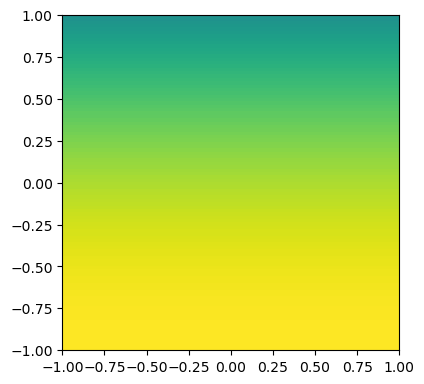

In [21]:
extend = [-1, 1, -1, 1]
plt.figure(figsize=(20, 4.355))
plt.subplot(141)
step=360
plt.imshow(1-xx*xx-yy*yy, interpolation='nearest', cmap='viridis',
               extent=extend, origin='lower', aspect='auto')
    #plt.xlabel('x', fontsize=15)
    #plt.ylabel('y', fontsize=15)
# plt.title("t="+str(step*dt), fontsize=20)
plt.clim(-1, 1)
plt.axis('equal')

(-1.0, 1.0, -1.0, 1.0)

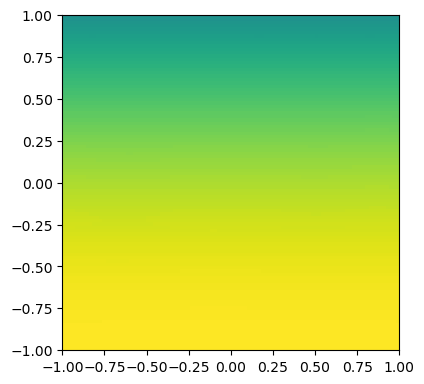

In [20]:
extend = [-1, 1, -1, 1]
plt.figure(figsize=(20, 4.355))
plt.subplot(141)
step=360
plt.imshow(zz, interpolation='nearest', cmap='viridis',
               extent=extend, origin='lower', aspect='auto')
    #plt.xlabel('x', fontsize=15)
    #plt.ylabel('y', fontsize=15)
# plt.title("t="+str(step*dt), fontsize=20)
plt.clim(-1, 1)
plt.axis('equal')